## Preperations

In [4]:
#Importing the important libraries
import pandas as pd
import geopandas as gp
import folium
from shapely import Polygon
import contextily as cx
import h3

In [5]:
# Readin POI Data
df = pd.read_pickle("data/poi/poi_prepared.pickle")

In [6]:
df

amenity  \
osmid                         
258490031           parking   
269449042  parking_entrance   
269450074  parking_entrance   
269688947          post_box   
270863340  parking_entrance   
...                     ...   
13621412                NaN   
13621413                NaN   
13621414                NaN   
15910906                NaN   
15910907                NaN   

                                                    geometry name  \
osmid                                                               
258490031                         POINT (-87.64385 41.95123)  NaN   
269449042                         POINT (-87.61506 41.85869)  NaN   
269450074                         POINT (-87.58421 41.79174)  NaN   
269688947                         POINT (-87.77220 42.00407)  NaN   
270863340                         POINT (-87.61564 41.86421)  NaN   
...                                                      ...  ...   
13621412   POLYGON ((-87.66859 41.91735, -87.66895 41.917...  NaN   
13621413   POLYGON ((-87.66793 41.91671, -87.66797 41.916...  NaN   
13621414   POLYGON ((-87.66801 41.91728, -87.66800 41.917...  NaN   
15910906   POLYGON ((-87.62624 41.87979, -87.62623 41.879...  NaN   
15910907   POLYGON ((-87.62610 41.87984, -87.62610 41.880...  NaN   

                   category   latitude  longitude public_transport wheelchair  \
osmid                                                                           
258490031           parking  41.951227 -87.643847              NaN        NaN   
269449042           parking  41.858689 -87.615058              NaN        NaN   
269450074           parking  41.791742 -87.584208              NaN        NaN   
269688947             other  42.004073 -87.772198              NaN        NaN   
270863340           parking  41.864208 -87.615638              NaN        NaN   
...                     ...        ...        ...              ...        ...   
13621412   public_transport  41.917203 -87.668448         platform        NaN   
13621413   public_transport  41.917215 -87.668182         platform        NaN   
13621414   public_transport  41.917277 -87.668066         platform        NaN   
15910906   public_transport  41.879543 -87.626201         platform         no   
15910907   public_transport  41.879567 -87.626064         platform         no   

                     hex_7            hex_8            hex_9  \
osmid                                                          
258490031  872664c14ffffff  882664c145fffff  892664c144fffff   
269449042  872664c1bffffff  882664c1b1fffff  892664c1b03ffff   
269450074  872664cc5ffffff  882664cc59fffff  892664cc583ffff   
269688947  872664d9effffff  882664d9e1fffff  892664d9e0fffff   
270863340  872664c1bffffff  882664c1bdfffff  892664c1bc7ffff   
...                    ...              ...              ...   
13621412   872664c12ffffff  882664cac9fffff  892664cac93ffff   
13621413   872664c12ffffff  882664cac9fffff  892664cac93ffff   
13621414   872664c12ffffff  882664cac9fffff  892664cac93ffff   
15910906   872664c1affffff  882664c1a9fffff  892664c1a87ffff   
15910907   872664c1affffff  882664c1a9fffff  892664c1a87ffff   

                                                       pol_7  \
osmid                                                          
258490031  POLYGON ((-87.63414405293 41.96445315471353, -...   
269449042  POLYGON ((-87.61820944356228 41.8710984903598,...   
269450074  POLYGON ((-87.5937067068291 41.798228672497444...   
269688947  POLYGON ((-87.7773181551225 42.01982017726515,...   
270863340  POLYGON ((-87.61820944356228 41.8710984903598,...   
...                                                      ...   
13621412   POLYGON ((-87.6723729663648 41.93963771855481,...   
13621413   POLYGON ((-87.6723729663648 41.93963771855481,...   
13621414   POLYGON ((-87.6723729663648 41.93963771855481,...   
15910906   POLYGON ((-87.63912440648137 41.88713767856642...   
15910907   POLYGON ((-87.63912440648137 41.88713767856642...   

In [7]:
# Building a Series of all hexcodes and their polygons
hex_series_9 = pd.Series(df['pol_9'].drop_duplicates().values, index=df['hex_9'].drop_duplicates().values)
hex_series_8 = pd.Series(df['pol_8'].drop_duplicates().values, index=df['hex_8'].drop_duplicates().values)
hex_series_7 = pd.Series(df['pol_7'].drop_duplicates().values, index=df['hex_7'].drop_duplicates().values)

In [8]:
# Creating Counts for the Categories
grouped_DF_9 = pd.DataFrame(df.groupby(["hex_9", "category"]).count()["hex_8"]).reset_index().set_index("hex_9").rename(columns = {"hex_8": "count"})
grouped_DF_8 = pd.DataFrame(df.groupby(["hex_8", "category"]).count()["hex_7"]).reset_index().set_index("hex_8").rename(columns = {"hex_7": "count"})
grouped_DF_7 = pd.DataFrame(df.groupby(["hex_7", "category"]).count()["hex_9"]).reset_index().set_index("hex_7").rename(columns = {"hex_9": "count"})

In [9]:
# Method that returs a Geodataframe with all Hexagons and the amount of a certain category of POIs that are in the hexagon
# Hexagons, in which no POIs of any category lay in, are not displayed
def countGDF(resolution, category, fillzeros):
    if (resolution == 9):
        df = grouped_DF_9
        series = hex_series_9
    elif (resolution == 8):
        df = grouped_DF_8
        series = hex_series_8
    else:
        df = grouped_DF_7
        series = hex_series_7
    df = df[df["category"] == category]
    df = df.join(series.to_frame(), how="right").rename(columns={0: "geometry"})
    if fillzeros:
        df['count'] =  df['count'].fillna(0)
    #df['category'] =  df['category'].fillna("placeholder")
    return gp.GeoDataFrame(df, geometry='geometry', crs = "EPSG:4326")

In [10]:
#Method to convert the hexagons to polygons using H3
def convert_hex_to_polygon(hex):
        polygon = None
        if hex:
               polygon = Polygon(h3.h3_to_geo_boundary(hex, geo_json=True))         
        return polygon

In [31]:
# Second Method, that returs a Geodataframe with all Hexagons and the amount of a certain category of POIs that are in the hexagon
# Does not need a list of hexagons and polygons in advance
# Thus hexagons, where no POIs of the category lay in, are not displayed
def countGDF2(resolution, category, fillzeros):
    if (resolution == 9):
        df = grouped_DF_9
        series = hex_series_9
    elif (resolution == 8):
        df = grouped_DF_8
        series = hex_series_8
    else:
        df = grouped_DF_7
        series = hex_series_7
    df = df[df["category"] == category].reset_index()
    df["geometry"] = df["hex_"+str(resolution)].apply(convert_hex_to_polygon)
    df = df.set_index("hex_"+str(resolution))
    if fillzeros:
        df['count'] =  df['count'].fillna(0)
    #df['category'] =  df['category'].fillna("placeholder")
    return gp.GeoDataFrame(df, geometry='geometry', crs = "EPSG:4326")

In [32]:
# Second Metho
countGDF2(7, "public_transport", False)

category  count  \
hex_7                                      
872664190ffffff  public_transport     19   
872664191ffffff  public_transport     32   
872664193ffffff  public_transport     23   
872664194ffffff  public_transport     95   
872664195ffffff  public_transport      8   
...                           ...    ...   
872759368ffffff  public_transport     19   
872759369ffffff  public_transport     61   
87275936bffffff  public_transport     44   
87275936cffffff  public_transport      4   
87275936dffffff  public_transport     60   

                                                          geometry  
hex_7                                                               
872664190ffffff  POLYGON ((-87.55709 41.68903, -87.56978 41.680...  
872664191ffffff  POLYGON ((-87.53629 41.67300, -87.54898 41.664...  
872664193ffffff  POLYGON ((-87.56572 41.66867, -87.57840 41.660...  
872664194ffffff  POLYGON ((-87.54846 41.70939, -87.56115 41.701...  
872664195ffffff  POLYGON ((-87.52765 41.69336, -87.54035 41.685...  
...                                                            ...  
872759368ffffff  POLYGON ((-87.83653 42.01096, -87.84925 42.002...  
872759369ffffff  POLYGON ((-87.81550 41.99494, -87.82822 41.986...  
87275936bffffff  POLYGON ((-87.84509 41.99051, -87.85780 41.982...  
87275936cffffff  POLYGON ((-87.82797 42.03142, -87.84069 42.023...  
87275936dffffff  POLYGON ((-87.80693 42.01539, -87.81965 42.007...  

[147 rows x 3 columns]

In [18]:
countGDF(7, "public_transport", False)

category  count  \
872664c14ffffff  public_transport   25.0   
872664c1bffffff  public_transport  121.0   
872664cc5ffffff  public_transport  176.0   
872664d9effffff  public_transport   46.0   
872664c1effffff  public_transport  430.0   
...                           ...    ...   
872664cb6ffffff  public_transport    6.0   
872664571ffffff  public_transport   12.0   
872664192ffffff               NaN    NaN   
872664190ffffff  public_transport   19.0   
87266456dffffff               NaN    NaN   

                                                          geometry  
872664c14ffffff  POLYGON ((-87.63414 41.96445, -87.64689 41.956...  
872664c1bffffff  POLYGON ((-87.61821 41.87110, -87.63093 41.862...  
872664cc5ffffff  POLYGON ((-87.59371 41.79823, -87.60642 41.789...  
872664d9effffff  POLYGON ((-87.77732 42.01982, -87.79005 42.011...  
872664c1effffff  POLYGON ((-87.63049 41.90755, -87.64322 41.899...  
...                                                            ...  
872664cb6ffffff  POLYGON ((-87.82407 41.97450, -87.83678 41.966...  
872664571ffffff  POLYGON ((-87.69564 41.68762, -87.70829 41.679...  
872664192ffffff  POLYGON ((-87.58653 41.68469, -87.59921 41.676...  
872664190ffffff  POLYGON ((-87.55709 41.68903, -87.56978 41.680...  
87266456dffffff  POLYGON ((-87.57434 41.64832, -87.58702 41.640...  

[155 rows x 3 columns]

In [35]:
# Method to plotting the count a a certain category in a certain hexagon with Folium
def plotCountFolium(resolution, category):
    # Creating a fitting geoJson for plotting with Folium
    gdf = countGDF(resolution, category, True)
    gdf.index.name = None
    gdf = gdf.reset_index()
    gjson = gdf.to_json()

    # Plotting with Folium
    m = folium.Map([41.88065, -87.62642], zoom_start=10,width=700,height=700)
    folium.Choropleth(
            geo_data=gjson,
            name="choropleth",
            data=gdf,
            columns=["index", "count"],
            key_on='feature.properties.index',
            fill_opacity=0.7,
            line_opacity=0.2,
            fill_color="YlGn",
            legend_name="Amount of " + category + "",
            line_color='black').add_to(m)
    return m

In [36]:
# Method to plotting the count a a certain category in a certain hexagon with Folium
def plotCountFolium2(resolution, category):
    # Creating a fitting geoJson for plotting with Folium
    gdf = countGDF2(resolution, category, True)
    gdf.index.name = None
    gdf = gdf.reset_index()
    gjson = gdf.to_json()

    # Plotting with Folium
    m = folium.Map([41.88065, -87.62642], zoom_start=10,width=700,height=700)
    folium.Choropleth(
            geo_data=gjson,
            name="choropleth",
            data=gdf,
            columns=["index", "count"],
            key_on='feature.properties.index',
            fill_opacity=0.7,
            line_opacity=0.2,
            fill_color="YlGn",
            legend_name="Amount of " + category + "",
            line_color='black').add_to(m)
    return m

In [37]:
# Method to plotting the count a a certain category in a certain hexagon with geopandas and contextily
def plotCountMPL(resolution, category):
    gdf = countGDF(resolution, category, True)
    ax= gdf.plot(figsize=(5, 5), column='count', cmap='summer', legend=True)
    cx.add_basemap(ax, crs=gdf.crs.to_string(), source = cx.providers.Stamen.Terrain)
    ax.axis('off')
    return ax.plot()

## Descriptive Analysis

There are these categories:

In [38]:
print(df.groupby("category").count()["geometry"].sort_values(ascending=False).to_string())

category
public_transport          16443
parking                    6841
gastronomy                 5281
other                      2952
place_of_worship           1881
education                  1437
bicycle_parking             835
bicycle_rental              815
finance                     590
health                      486
fuel                        418
culture                     177
water_transport             166
children                     52
police                       38
nightlife                    24
car_rental                   24
bicycle_repair_station       19
taxi                         10
car_sharing                   2
sports                        2


Lets have a look at some that might give us an insight about how the city of Chicago is structured.

But before that lets use the public transport examples to decide for a hexagon resolution.

### Public Transport

In [39]:
plotCountFolium(7, "public_transport")

In [40]:
plotCountFolium2(7, "public_transport")

In [23]:
# Plot with Resolution 8
# There are some hexagons where no POIs are in
plotCountFolium(8, "public_transport")

In [10]:
# Plot with Resolution 9
# There are many hexagons that dont contain any POIs
plotCountFolium(9, "public_transport")

After comparing the different Hexagon Resolutions we decide to use a resolution of 7 for later analysis.

This means, that every hexagon has [a size of 5.16 km<sup>2</sup>](https://h3geo.org/docs/core-library/restable).

| Res | Average Hexagon Area (km<sup>2</sup>) |
|-----|----------------------------|
| 7   | 5.161293360                |
| 8   | 0.737327598                |
| 9   | 0.105332513                |

Now lets try to find something out about how the city is structured in terms of public transport.

In [12]:
plotCountFolium(7, "public_transport")

We can see that the city center is also home to most public transport stations.

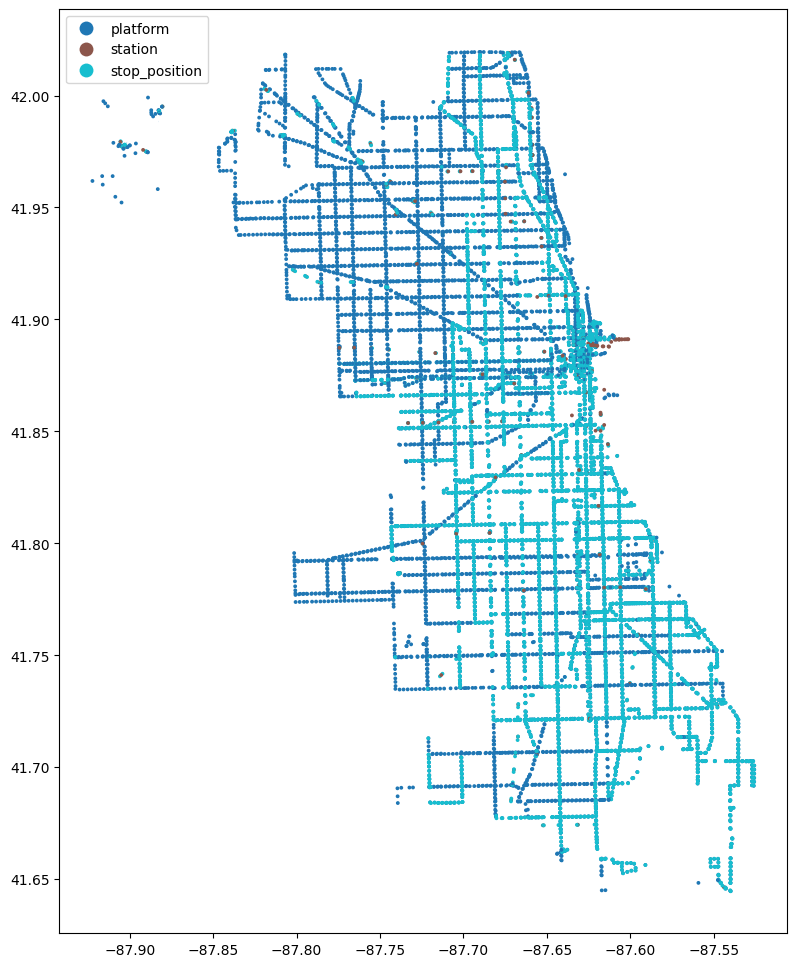

In [13]:
testDF2 = df[df["public_transport"].notna()]
ax = testDF2.plot(column='public_transport', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left'))

This graph shows where "platforms", "stations" and "stop_positions" are spread over the city. We can understand what that means with the following table from the [OSM-Wiki](https://wiki.openstreetmap.org/wiki/Key:public_transport).
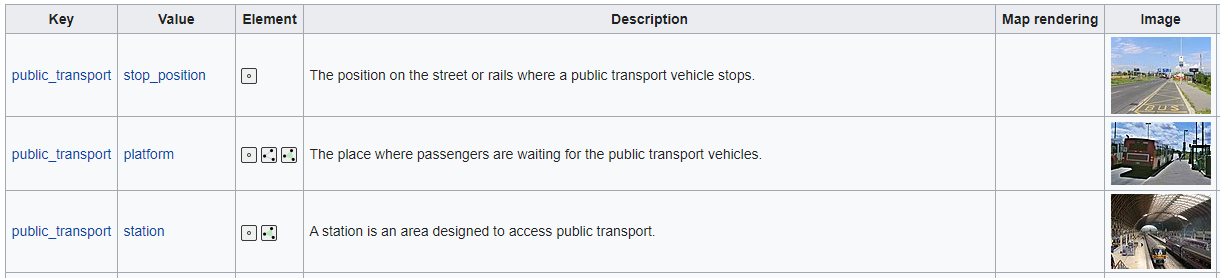

### Parking

In [11]:
plotCountFolium(7, "parking")

### Gastronomy

In [159]:
plotCountFolium(7, "gastronomy")

In [174]:
#places = ["pub", "cafe", "restaurant"]
places = ["pub"]
testDF = df[df["amenity"].isin(places)]
m = plotCountFolium(7, "gastronomy")
for index, row in testDF.iterrows():
    if row["amenity"] == "cafe":
        folium.Marker(location=(row["latitude"],row["longitude"]) , icon=folium.Icon(icon="mug-saucer", prefix='fa',color = "pink")).add_to(m)
    elif row["amenity"] == "restaurant":
        folium.Marker(location=(row["latitude"],row["longitude"]), icon=folium.Icon(icon="utensils", prefix='fa',color = "green")).add_to(m)
    else:
        folium.Marker(location=(row["latitude"],row["longitude"]), icon=folium.Icon(icon="beer", prefix='fa',color = "orange")).add_to(m)

m

In [173]:
#places = ["pub", "cafe", "restaurant"]
places = ["cafe"]
testDF = df[df["amenity"].isin(places)]
m = plotCountFolium(7, "gastronomy")
for index, row in testDF.iterrows():
    if row["amenity"] == "cafe":
        folium.Marker(location=(row["latitude"],row["longitude"]) , icon=folium.Icon(icon="mug-saucer", prefix='fa',color = "pink")).add_to(m)
    elif row["amenity"] == "restaurant":
        folium.Marker(location=(row["latitude"],row["longitude"]), icon=folium.Icon(icon="utensils", prefix='fa',color = "green")).add_to(m)
    else:
        folium.Marker(location=(row["latitude"],row["longitude"]), icon=folium.Icon(icon="beer", prefix='fa',color = "orange")).add_to(m)

m

In [176]:
#places = ["pub", "cafe", "restaurant"]
places = ["restaurant"]
testDF = df[df["amenity"].isin(places)]
m = plotCountFolium(7, "gastronomy")
for index, row in testDF.iterrows():
    if row["amenity"] == "cafe":
        folium.Marker(location=(row["latitude"],row["longitude"]) , icon=folium.Icon(icon="mug-saucer", prefix='fa',color = "pink")).add_to(m)
    elif row["amenity"] == "restaurant":
        folium.Marker(location=(row["latitude"],row["longitude"]), icon=folium.Icon(icon="utensils", prefix='fa',color = "green")).add_to(m)
    else:
        folium.Marker(location=(row["latitude"],row["longitude"]), icon=folium.Icon(icon="beer", prefix='fa',color = "orange")).add_to(m)

m

### Health 

In [160]:
plotCountFolium(7, "health")

### Culture 

In [161]:
plotCountFolium(7, "culture")

### Nightlife 

In [162]:
plotCountFolium(7, "nightlife")

We can see that many of the Points of Interest are near the city center. As there are many gastronomy and culture related POIs in the city center, we expect many rides to and from this area.